# Валидная разметка медицинских изображений

Импорт системных модулей:

In [1]:
import os
from glob import glob

Импорт дополнительных библиотек:

In [2]:
%matplotlib inline

import numpy as np
import pydicom
import matplotlib
plt = matplotlib.pyplot

### Генерация файла *requirements.txt*

In [3]:
status = False 
if status == True:
    req_file = open('requirements.txt', 'w')
    req_file.write('numpy ' + np.__version__ + '\n')
    req_file.write('pydicom ' + pydicom.__version__ + '\n')
    req_file.write('matplotlib ' + matplotlib.__version__ + '\n')
    req_file.close()

## Загрузка данных

### Настройка путей для загрузки и записи новых данных:

In [4]:
data_path = '/home/alexey/SCIENTIFIC_WORK/ct_locator_sample'
output_path = working_path = '/home/alexey/SCIENTIFIC_WORK/valid_marking_of_medical_images/output_data/'
dicom_file_name = glob(data_path + '/*')

print ('Total of %d DICOM images.' % len(dicom_file_name))

Total of 1149 DICOM images.


Создаю список с именами всех файлов в директории:

In [5]:
files = [name for name in os.listdir(data_path)]

Функция для загрузки и отображения выбранного файла по его номеру:

In [6]:
def load_image(file_number):
    dicom_image = pydicom.read_file(data_path + '/' + files[file_number])
    img = dicom_image.pixel_array
    fig, ax = plt.subplots(1, 1, figsize=[12, 12])
    ax.set_title('DICOM-изображение, полученное с лаколайзера')
    ax.imshow(img, cmap='gray')
    ax.axis('on')
    
    plt.show()
    return dicom_image

Функция для отображения **Pixel Array**:

In [7]:
def show_pixel_array(file, title):
    fig, ax = plt.subplots(1, 1, figsize=[12, 12])
    ax.set_title(title)
    ax.imshow(file, cmap='gray')
    ax.axis('on')
    
    plt.show()

Пробуем загрудить первый снимок из нашего списка:

In [8]:
load_image(0)

RuntimeError: The following handlers are available to decode the pixel data however they are missing required dependencies: GDCM (req. GDCM)

***
# ОШИБКА!

### Что-то не то с данными! На некоторых файлах выскакивает данная ошибка!

### Очень странный момент, потому что на некоторых файлах работает так, как ожидается.

#### Вот пример (выбран '1_1.2.840.113704.1.111.432.1401988139.74552.dcm' потому что он отрывался и ранее):

In [9]:
for i in range(len(dicom_file_name)):
    if files[i] == '1_1.2.840.113704.1.111.432.1401988139.74552.dcm':
        print(i)

64


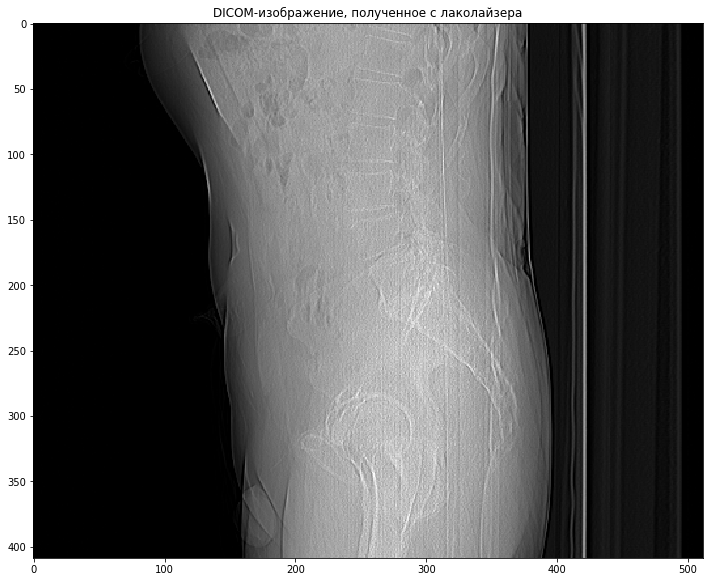

In [10]:
image = load_image(64)

# Работа с Overlay Data

**Overlays** в DICOM присутствуют в так называемой повторяющейся группе (Repeating Group), где номер группы тегов элемента определяется по диапазону, а не по определенному значению. Например, номер группы тега для (60xx, 3000) оверлейных данных может быть 6000, 6002 или любое четное значение до 601E. Это позволяет в набор данных включать несколько **overlays**, где связанные элементы для каждого наложения используют один и тот же номер группы. Из-за этого единственный способ получить доступ к определенному элементу из оверлея - использовать метод `Dataset [group, elem]`.

Рассмотрим снимок с **overlays** c вязтый с git-репозитория [pydicom](https://github.com/pydicom/pydicom/blob/master/pydicom/data/test_files/MR-SIEMENS-DICOM-WithOverlays.dcm) от [Dicom in Python](https://github.com/pydicom) на GitHub:

In [11]:
data_set = pydicom.dcmread('MR-SIEMENS-DICOM-WithOverlays.dcm')
element = data_set[0x6000, 0x3000]  # returns a DataElement
print(element)

(6000, 3000) Overlay Data                        OW: Array of 29282 elements


По умолчанию **Pydicom** ничего не делает с **Overlay Data**, кроме чтения в необработанных байтах:

In [12]:
element.value[:10]

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'

Чтобы распаковать и получить **Overlay Data** в более полезной форме, следует использовать метод `overlay_array()` для возврата `numpy.ndarray`. Чтобы использовать его, нкжно просто передать номер группы интересующих элементов **Overlay Data**: `data_set.overlay_array(0x6000)`.

При работе с **Overlay Data** нужно помнить, что верхний левый угол **Overlay** не обязательно должен совпадать с верхним левым краем соответствующих данных пикселей. Фактическое смещение между ними можно определить из `(60xx, 0050) Overlay Origin`, где значение [1, 1] указывает, что верхние левые пиксели выровнены, а значение [0, 0] указывает, что оверлейные пиксели начинаются на одну строку выше и на одну строку левее от пикселей изображения.

*NumPy* может использоваться для изменения пикселей, но если изменения должны быть сохранены, они должны быть упакованы битами и записаны обратно в правильный элемент:

In [13]:
arr = data_set.overlay_array(0x6000)

In [14]:
arr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

*NumPy* может использоваться для изменения пикселей, но если изменения должны быть сохранены, они должны быть упакованы битами и записаны обратно в правильный элемент:

In [15]:
# Add a line
arr[100, :] = 1

In [16]:
# Pack the data
from pydicom.pixel_data_handlers.numpy_handler import pack_bits
packed_bytes = pack_bits(arr)

# Pad the value if odd-length
if len(packed_bytes) % 2:
    packed_bytes += b'\x00'

# Update the element value
data_set[0x6000, 0x3000].value = packed_bytes
data_set.save_as("temp.dcm")

ValueError: Only 1D arrays are supported.

***
# ОШИБКА!

### Не удается упаковать изменения битами!

### Пишет, что массив должен быть одномерным, не понятно, что с этим делать. Так я преследую другую цель пока что отложу этот момент.

Некоторые изменения могут потребовать изменения других элементов DICOM. Например, если данные наложения уменьшены (например, изображение 512x512 свернуто до 256x256), то соответствующие (60xx, 0010) строки наложения и (60xx, 0011) столбцы наложения должны быть установлены соответствующим образом. Вы должны явно установить их самостоятельно; Pydicom не делает это автоматически.

# Попытка разметки изображений

Загружаю уже прорверенное изображение:

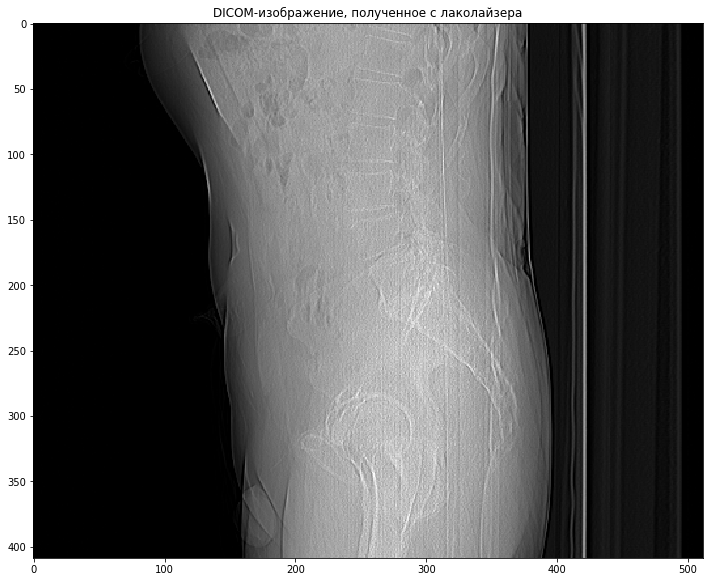

In [17]:
new_image = load_image(64)

Выведу его метаданные на экран:

In [18]:
new_image

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'LOCALIZER']
(0008, 0012) Instance Creation Date              DA: '19800101'
(0008, 0013) Instance Creation Time              TM: '555555'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113704.1.111.432.1401988139.74552
(0008, 0020) Study Date                          DA: '19800101'
(0008, 0022) Acquisition Date                    DA: '19800101'
(0008, 0023) Content Date                        DA: '19800101'
(0008, 002a) Acquisition DateTime                DT: ''
(0008, 0030) Study Time                          TM: '555555'
(0008, 0032) Acquisition Time                    TM: '555555'
(0008, 0033) Content Time                        TM: '555555'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CT'
(0008

Получим только пиксели изображения из данного `dicom`-файла и отобразим их:

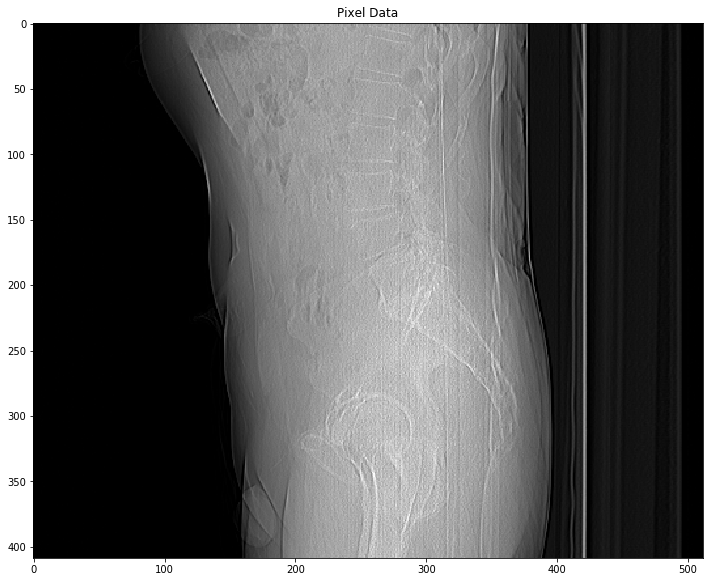

In [19]:
pixel_array = new_image.pixel_array
show_pixel_array(pixel_array, 'Pixel Data')

Видно, что на этом снимке находятся области брюшной полости и малого таза. Выделим их в отдельные массивы:

In [20]:
abdomen_array = pixel_array[0:170, :]
pelvis_array = pixel_array[170:, :]

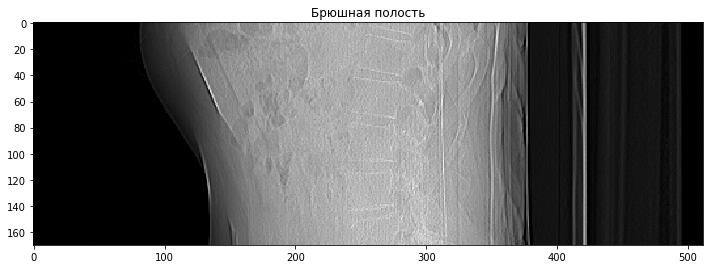

In [21]:
show_pixel_array(abdomen_array, 'Брюшная полость')

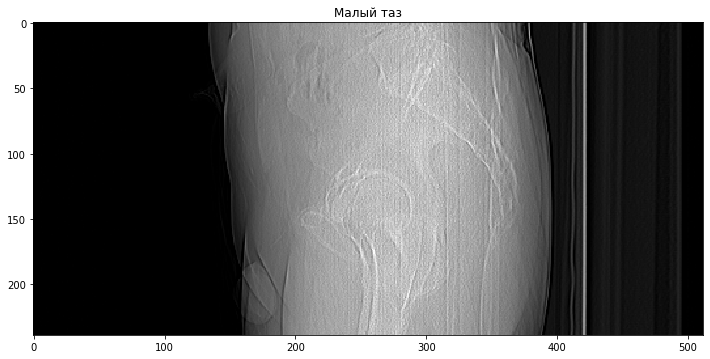

In [22]:
show_pixel_array(pelvis_array, 'Малый таз')

# Добавие элементов словаря в стандартный словарь DICOM

In [23]:
from pydicom.datadict import DicomDictionary, keyword_dict
from pydicom.dataset import Dataset

In [24]:
new_dict_items = {
    0x60003000: ('OW', '1', "Annotation: Abdomen", '', 'Abdomen'),
    0x60013001: ('OW', '1', "Annotation: Pelvis", '', 'Pelvis'),
}

In [25]:
DicomDictionary.update(new_dict_items)

In [26]:
new_names_dict = dict([(val[4], tag) for tag, val in new_dict_items.items()])
keyword_dict.update(new_names_dict)

In [27]:
new_image.Abdomen = abdomen_array
new_image.Pelvis = pelvis_array

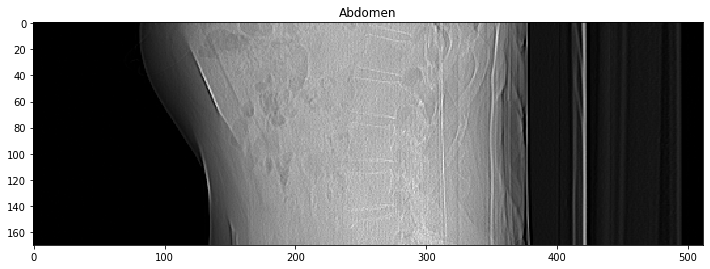

In [28]:
show_pixel_array(new_image.Abdomen, 'Abdomen')

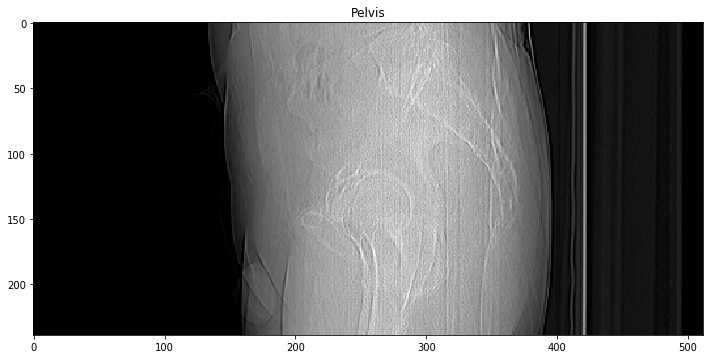

In [29]:
show_pixel_array(new_image.Pelvis, 'Pelvis')

Посмотрим теперь на метаданные нашего снимка:

In [30]:
new_image

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'LOCALIZER']
(0008, 0012) Instance Creation Date              DA: '19800101'
(0008, 0013) Instance Creation Time              TM: '555555'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113704.1.111.432.1401988139.74552
(0008, 0020) Study Date                          DA: '19800101'
(0008, 0022) Acquisition Date                    DA: '19800101'
(0008, 0023) Content Date                        DA: '19800101'
(0008, 002a) Acquisition DateTime                DT: ''
(0008, 0030) Study Time                          TM: '555555'
(0008, 0032) Acquisition Time                    TM: '555555'
(0008, 0033) Content Time                        TM: '555555'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CT'
(0008

# А вот малый таз не переименовал! Странно!
Созраним данные изменения:

In [31]:
new_image.save_as('saved_file.dcm')

# Проверка работы

In [32]:
dicom_image = pydicom.read_file('saved_file.dcm')

In [33]:
dicom_image.Abdomen[:10]

b'\x00\x00\x00\x00\x00\x00\x0e\x00\x01\x00'

In [34]:
dicom_image.Pelvis[:10]

b'\x00\x00\x00\x00\x00\x00\x00\x00\x02\x00'

# Хех! Упокавались сами в биты!)) Я не понимаю, как это произошло))
Ну попробуем отобразить это дело:

In [35]:
abdomen = dicom_image.overlay_array(0x6001)

AttributeError: Unable to convert the overlay data as the following required elements are missing from the dataset: OverlayData, OverlayBitsAllocated, OverlayRows, OverlayColumns

# Хммм 
А это интересный момент, получается больше одного наложения не можем сделаьть??? 